In [ ]:
import torch
from torch import nn, optim
from torchvision import datasets, transforms
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [3]:
# --- data (keep yours) ---
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])
train_dir = "data_classification/augmented/train"
test_dir  = "data_classification/augmented/test"
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
test_dataset  = datasets.ImageFolder(root=test_dir,  transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True,  num_workers=4, pin_memory=True)
test_loader  = torch.utils.data.DataLoader(test_dataset,  batch_size=128, shuffle=False, num_workers=4, pin_memory=True)
print("class_to_idx:", train_dataset.class_to_idx)
num_classes = len(train_dataset.classes)

# --- DINOv2 backbone (frozen) ---
model = torch.hub.load("facebookresearch/dinov2", "dinov2_vits14").to(device)
for p in model.parameters(): p.requires_grad = False

# DINOv2 ViT-S/14 has 384-d CLS features
feat_dim_backbone = 384

# IMPORTANT: make forward() return features, not logits
#            In DINOv2, forward returns head(cls_feats) if head is set.
#            So set head to Identity() → forward returns features.
model.head = nn.Identity()

# --- small trainable projection + center loss ---
proj_dim = 128
feat_proj = nn.Linear(feat_dim_backbone, proj_dim).to(device)

class CenterLoss(nn.Module):
    def __init__(self, num_classes: int, feat_dim: int, device):
        super().__init__()
        self.centers = nn.Parameter(torch.randn(num_classes, feat_dim, device=device))
    def forward(self, features: torch.Tensor, labels: torch.Tensor):
        centers_batch = self.centers[labels]          # labels must be Long
        return ((features - centers_batch) ** 2).sum() / (2.0 * features.size(0))

center_loss_fn = CenterLoss(num_classes=num_classes, feat_dim=proj_dim, device=device)

optimizer = optim.Adam([
    {"params": feat_proj.parameters(), "lr": 1e-3},
    {"params": center_loss_fn.parameters(), "lr": 5e-4},  # smaller LR for centers
])

# --- train / eval with center loss only + nearest-center classification ---
def train_one_epoch():
    model.eval()            # backbone frozen; eval() is fine
    feat_proj.train()
    running = 0.0
    for imgs, labels in train_loader:
        imgs = imgs.to(device, non_blocking=True)
        y = labels.to(device, non_blocking=True).long()
        with torch.set_grad_enabled(True):
            feats_backbone = model(imgs)             # (N, 384) features (head=Identity)
            feats = feat_proj(feats_backbone)        # (N, 128)
            loss = center_loss_fn(feats, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running += loss.item() * imgs.size(0)
    return running / len(train_loader.dataset)

@torch.no_grad()
def evaluate_epoch():
    model.eval(); feat_proj.eval()
    correct = total = 0
    total_loss = 0.0
    centers = center_loss_fn.centers                  # (C, 128)
    for imgs, labels in test_loader:
        imgs = imgs.to(device, non_blocking=True)
        y = labels.to(device, non_blocking=True).long()
        feats = feat_proj(model(imgs))                # (N, 128)
        total_loss += center_loss_fn(feats, y).item() * imgs.size(0)
        dists = torch.cdist(feats, centers)           # (N, C) L2 distances
        preds = torch.argmin(dists, dim=1)            # nearest center
        correct += (preds == y).sum().item()
        total += y.size(0)
    return correct / total, total_loss / total


class_to_idx: {'Negative': 0, 'Positive': 1}


Using cache found in /home/ai-17/.cache/torch/hub/facebookresearch_dinov2_main


In [4]:
for epoch in range(10):
    tr_loss = train_one_epoch()
    acc, val_loss = evaluate_epoch()
    print(f"epoch {epoch+1}: train_center {tr_loss:.4f} | val_center {val_loss:.4f} | acc_nc {acc:.3f}")


epoch 1: train_center 55.3483 | val_center 29.6625 | acc_nc 0.802
epoch 2: train_center 24.5283 | val_center 19.9731 | acc_nc 0.806
epoch 3: train_center 18.4409 | val_center 17.0153 | acc_nc 0.843
epoch 4: train_center 16.0007 | val_center 15.3918 | acc_nc 0.866
epoch 5: train_center 14.4962 | val_center 14.2354 | acc_nc 0.848
epoch 6: train_center 13.4112 | val_center 13.2659 | acc_nc 0.857
epoch 7: train_center 12.5791 | val_center 12.7007 | acc_nc 0.876
epoch 8: train_center 11.8500 | val_center 12.2163 | acc_nc 0.880
epoch 9: train_center 11.2745 | val_center 11.7245 | acc_nc 0.885
epoch 10: train_center 10.8882 | val_center 11.8742 | acc_nc 0.862


              precision    recall  f1-score   support

    Negative     0.8629    0.9618    0.9096       157
    Positive     0.8571    0.6000    0.7059        60

    accuracy                         0.8618       217
   macro avg     0.8600    0.7809    0.8078       217
weighted avg     0.8613    0.8618    0.8533       217

Confusion Matrix:
 [[151   6]
 [ 24  36]]


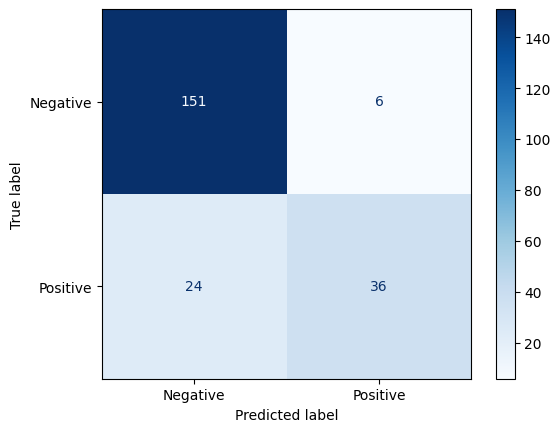

In [6]:

# ----- sklearn metrics (nearest-center) -----
@torch.no_grad()
def collect_preds_center():
    model.eval(); feat_proj.eval()
    y_true, y_pred = [], []
    centers = center_loss_fn.centers
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        feats = feat_proj(model(imgs))
        dists = torch.cdist(feats, centers)
        preds = torch.argmin(dists, dim=1).cpu().numpy()
        y_true.extend(labels.numpy())
        y_pred.extend(preds)
    return y_true, y_pred

y_true, y_pred = collect_preds_center()
print(classification_report(y_true, y_pred, target_names=train_dataset.classes, digits=4))
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)
ConfusionMatrixDisplay(cm, display_labels=train_dataset.classes).plot(cmap="Blues")
plt.show()
